In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


# Read data from an Excel file
ticker = '^DJA'
start = '2000-01-01'
end = '2024-04-01'
data = yf.download(ticker, start, end, interval='1wk')['Close']
price = data.values.flatten()
T = len(price)

# Create a date range starting from March 1871
date = pd.date_range(start='2000-01-01', periods=T, freq='w')

# Initial settings for the SADF test
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1

# Assuming 'price' and 'date' are already defined
log_price = np.array(np.log(price))
delta_log_price = log_price[1:] - log_price[:-1]

date_diff = date[1:]




[*********************100%%**********************]  1 of 1 completed


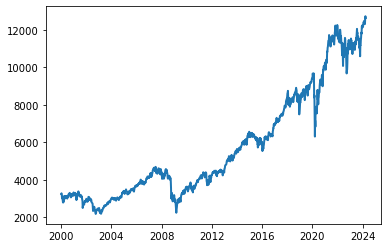

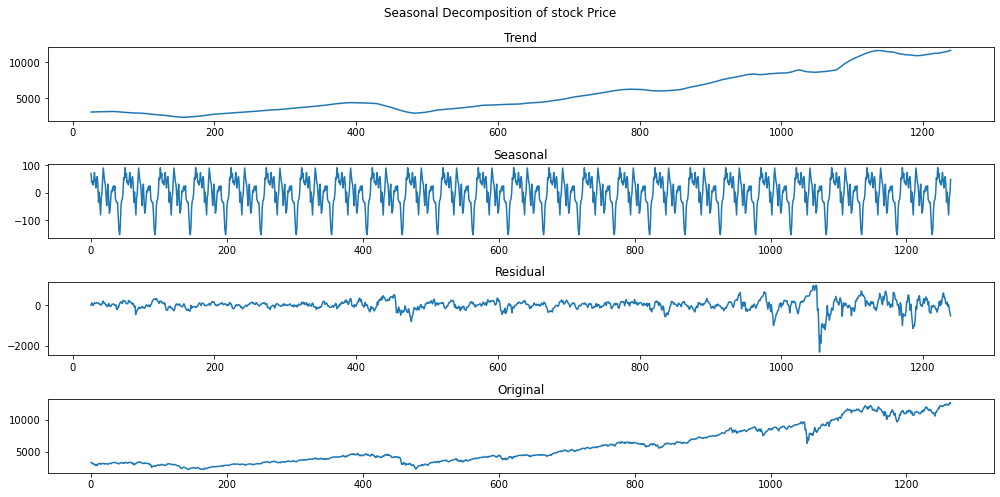

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


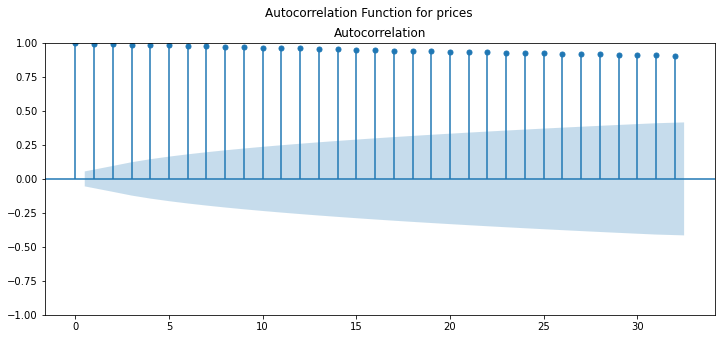

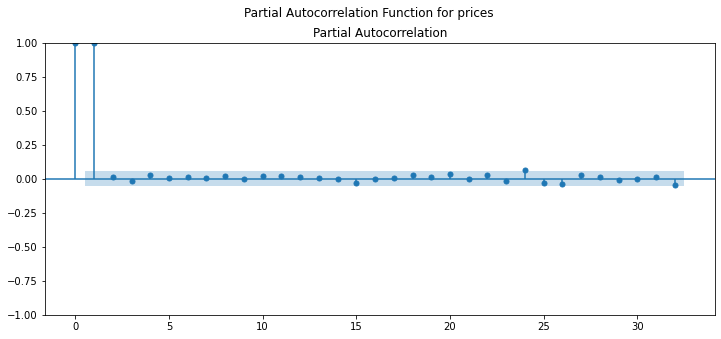

In [18]:

# Plotting the SP500 data
plt.figure(1)
plt.plot(date, price, linewidth=2)

decompositionp = seasonal_decompose(price, model = "additive", period = 52)

plt.figure(figsize=(14, 7))
plt.suptitle(f'Seasonal Decomposition of stock Price')
    
# Trend component
plt.subplot(411)
plt.plot(decompositionp.trend)
plt.title('Trend')
    
# Seasonal component
plt.subplot(412)
plt.plot(decompositionp.seasonal)
plt.title('Seasonal')
    
# Residual component
plt.subplot(413)
plt.plot(decompositionp.resid)
plt.title('Residual')
    
    # Original Data
plt.subplot(414)
plt.plot(price)
plt.title('Original')

    
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top spacing to accommodate the suptitle
plt.show()

plt.figure(figsize=(12, 5))
plt.suptitle(f'Autocorrelation Function for prices')
plot_acf(price, ax=plt.gca())
    
# Plot PACF
plt.figure(figsize=(12, 5))
plt.suptitle(f'Partial Autocorrelation Function for prices')
plot_pacf(price, ax=plt.gca())
plt.show()

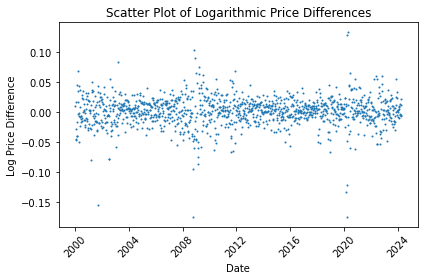

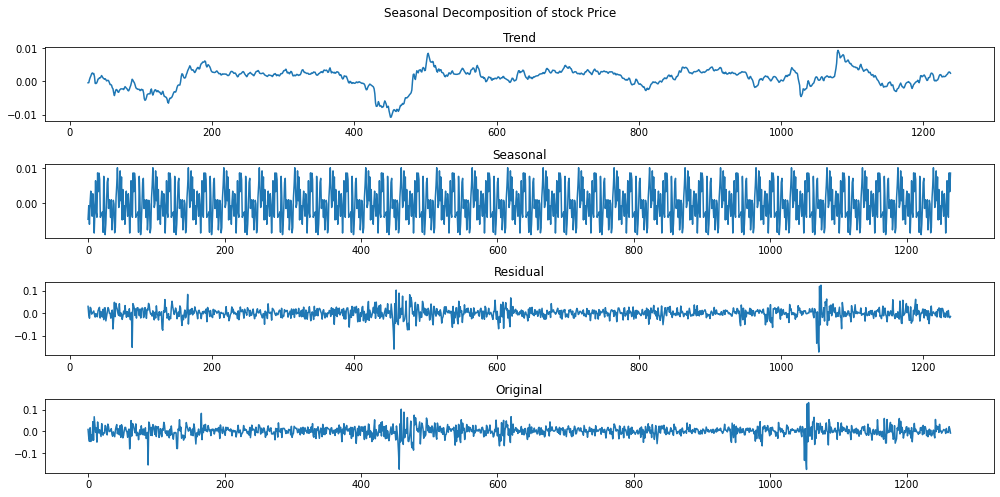

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


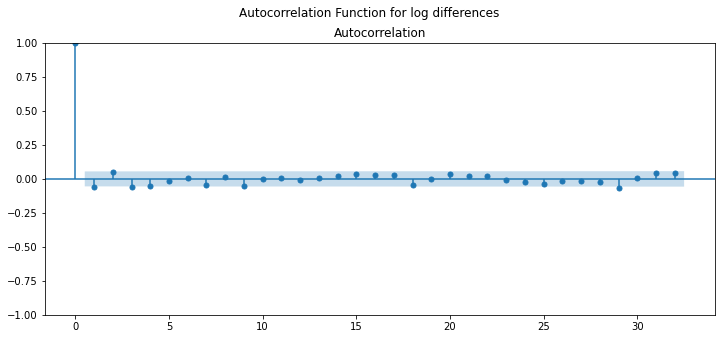

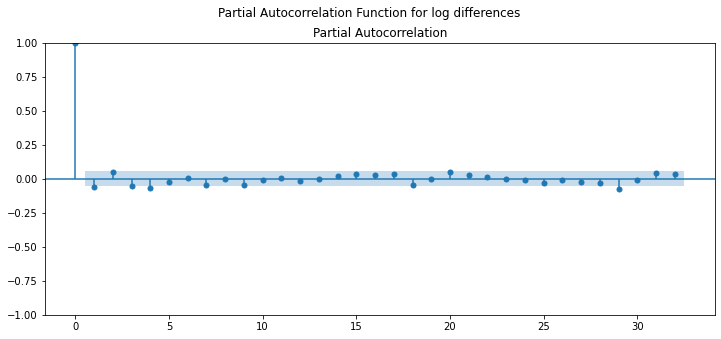

In [19]:
decompositionlog = seasonal_decompose(delta_log_price, model='additive', period=52)


# Creating a scatter plot

plt.scatter(date_diff, delta_log_price, s = 1)
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Log Price Difference')  # Label for the y-axis
plt.title('Scatter Plot of Logarithmic Price Differences')  # Title of the plot
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated date labels
plt.show()

plt.figure(figsize=(14, 7))
plt.suptitle(f'Seasonal Decomposition of stock Price')
    
# Trend component
plt.subplot(411)
plt.plot(decompositionlog.trend)
plt.title('Trend')
    
# Seasonal component
plt.subplot(412)
plt.plot(decompositionlog.seasonal)
plt.title('Seasonal')
    
# Residual component
plt.subplot(413)
plt.plot(decompositionlog.resid)
plt.title('Residual')
    
    # Original Data
plt.subplot(414)
plt.plot(delta_log_price)
plt.title('Original')



plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top spacing to accommodate the suptitle
plt.show()

plt.figure(figsize=(12, 5))
plt.suptitle(f'Autocorrelation Function for log differences')
plot_acf(delta_log_price, ax=plt.gca())
    
# Plot PACF
plt.figure(figsize=(12, 5))
plt.suptitle(f'Partial Autocorrelation Function for log differences')
plot_pacf(delta_log_price, ax=plt.gca())
plt.show()


In [20]:
def estimate_lag_effect(ts, lags):
    """
    Estimates the effect of lagged values on the current value of a time series.
    
    Parameters:
    - ts (pandas.Series or numpy.ndarray): The time series data.
    - lags (int): The number of lagged terms to include in the model.
    
    Returns:
    - result (RegressionResults): The regression results object from statsmodels.
    """
    # Ensure input is a pandas Series for ease of manipulation
    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)
    
    # Prepare the DataFrame to include lags using a more vectorized approach
    df = pd.concat([ts.shift(i) for i in range(lags + 1)], axis=1)
    df.columns = ['y'] + [f'lag_{i}' for i in range(1, lags + 1)]
    
    # Remove the rows with NaN values (these are the first 'lags' rows)
    df = df.dropna()

    # Define the independent variables (lagged values) and the dependent variable
    X = df.drop(columns='y')
    y = df['y']
    
    # Add a constant to the model (intercept)
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X)
    result = model.fit()
    
    return result

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.188
Date:                Mon, 15 Apr 2024   Prob (F-statistic):            0.00226
Time:                        19:38:24   Log-Likelihood:                 2890.8
No. Observations:                1261   AIC:                            -5772.
Df Residuals:                    1256   BIC:                            -5746.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.821      0.0

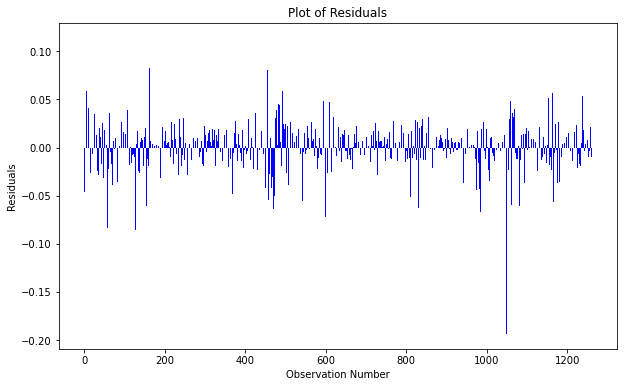

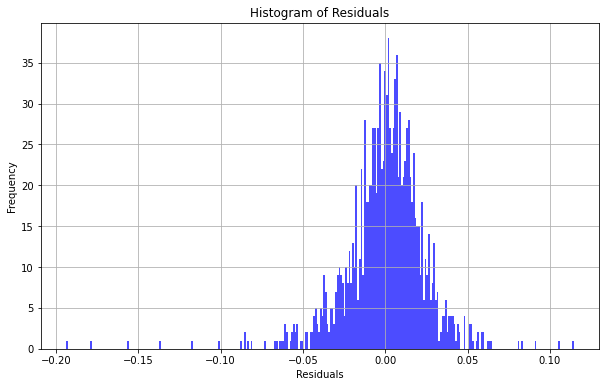

In [21]:
result = estimate_lag_effect(delta_log_price, lags=4)
print(result.summary())

residuals = result.resid

# Plotting the residuals on a bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(len(residuals)), residuals, color='blue')
plt.xlabel('Observation Number')
plt.ylabel('Residuals')
plt.title('Plot of Residuals')
plt.show()

# Plotting the residuals on a histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins= 300, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

In [22]:
# Function to calculate critical values (placeholder function, to be defined based on your method)
def calculate_critical_values(T, swindow0, quantiles):
    # This should return arrays or lists of critical values based on your specific needs
    return np.random.rand(3), np.random.rand(3)

# Simulating finite sample critical values
qe = [0.90, 0.95, 0.99]
cv_sadf, cv_badf = calculate_critical_values(T, swindow0, qe)
cv_gsadf, cv_bsadf = calculate_critical_values(T, swindow0, qe)


# Calculate the SADF statistic
dateS = date[swindow0:]

badfs = np.zeros(dim)
for i in range(swindow0, T):
    result = adfuller(delta_log_price[:i+1], maxlag=4, regression='c', autolag=None)
    badfs[i - swindow0] = result[0]
sadf = np.max(badfs)

print('The SADF statistic:', sadf)
print('The critical values:', cv_sadf)



The SADF statistic: 0.0
The critical values: [0.94940406 0.45197084 0.45112657]


In [23]:
# Calculate the Generalized SADF statistic
bsadfs = np.zeros(dim)
for r2 in range(swindow0, T):
    dim0 = r2 - swindow0 + 1
    rwadft = np.zeros(dim0)
    for r1 in range(dim0):
        result = adfuller(delta_log_price[r1:r2+1], maxlag=4, regression='c', autolag=None)
        rwadft[r1] = result[0]
    bsadfs[r2 - swindow0] = np.max(rwadft)

gsadf = np.max(bsadfs)

print('The GSADF statistic:', gsadf)
print('The critical values:', cv_gsadf)

In [ ]:
print(len(dateS), len(bsadfs), len(badfs), len(date), len(date_diff)) 


1190 1190 1190


In [ ]:
badfs = badfs[:-1]
bsadfs = bsadfs[:-1]


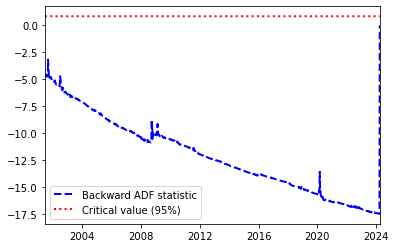

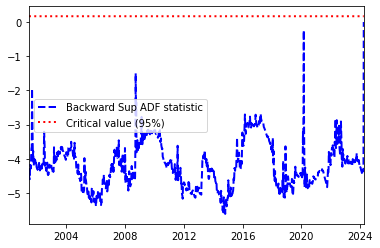

In [ ]:
# Plot the backward ADF statistics
plt.figure(1)
plt.plot(dateS, badfs, '--b', linewidth=2)
plt.plot(dateS, [cv_badf[1]]*len(dateS), ':r', linewidth=2)
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward ADF statistic', 'Critical value (95%)'])



# Plot the Generalized SADF statistics
plt.figure(2)
plt.plot(dateS, bsadfs, '--b', linewidth=2)
plt.plot(dateS, [cv_bsadf[1]]*len(dateS), ':r', linewidth=2)
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward Sup ADF statistic', 'Critical value (95%)'])
